In [47]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from cartopy.io.img_tiles import OSM, GoogleTiles, StadiaMapsTiles, MapQuestOSM

from pandasgui import show

#

import warnings

In [3]:
warnings.filterwarnings( 'ignore' )

In [4]:
gmID_list = cfs.list_gmIDs()

In [5]:
print( cfs.list_topics() )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [6]:
reference_red_route_best_pose_df = cfs.retrieve_gmID_topic( 'c0555ef0-f50f-11ee-8afa-cb629b0d53e6', '/apollo/sensor/gnss/best/pose' )

reference_green_route_best_pose_df = cfs.retrieve_gmID_topic( '5afabc8c-f035-11ee-b966-fb353e7798cd', '/apollo/sensor/gnss/best/pose' )

reference_blue_route_best_pose_df = cfs.retrieve_gmID_topic( '06cbdbc0-db4d-11ee-a158-97f8443fd730', '/apollo/sensor/gnss/best/pose' )

#

red_route_combined_df_list = []

green_route_combined_df_list = []

blue_route_combined_df_list = []

for gmID in gmID_list:

    #

    current_gmID_chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    current_gmID_best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    #

    current_gmID_chassis_df = current_gmID_chassis_df.sort_values( 'time' )

    current_gmID_best_pose_df = current_gmID_best_pose_df.sort_values( 'time' )

    #

    cfs.BinaryDrivingMode( current_gmID_chassis_df )

    cfs.TernaryDrivingModeTransition( current_gmID_chassis_df )

    #

    cfs.LatLonTotalStdDev( current_gmID_best_pose_df )

    #

    route = cfs.give_route( gmID )

    if ( route == 'Red' ):

        cfs.ProgressAlongRoute( current_gmID_best_pose_df, reference_red_route_best_pose_df )

    elif ( route == 'Green' ):

        cfs.ProgressAlongRoute( current_gmID_best_pose_df, reference_green_route_best_pose_df )

    else:

        cfs.ProgressAlongRoute( current_gmID_best_pose_df, reference_blue_route_best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( current_gmID_chassis_df, current_gmID_best_pose_df )

    #

    current_gmID_combined_df = pd.merge( current_gmID_chassis_df, current_gmID_best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    if ( route == 'Red' ):

        red_route_combined_df_list.append( current_gmID_combined_df )

    elif ( route == 'Green' ):

        green_route_combined_df_list.append( current_gmID_combined_df )

    else:

        blue_route_combined_df_list.append( current_gmID_combined_df )

In [7]:
red_route_combined_df_all = pd.concat( red_route_combined_df_list )

green_route_combined_df_all = pd.concat( green_route_combined_df_list )

blue_route_combined_df_all = pd.concat( blue_route_combined_df_list )

In [8]:
red_route_disengagement_subset_df = red_route_combined_df_all[ red_route_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]

green_route_disengagement_subset_df = green_route_combined_df_all[ green_route_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]

blue_route_disengagement_subset_df = blue_route_combined_df_all[ blue_route_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]

#

red_route_disengagement_subset_df_copy = red_route_disengagement_subset_df.copy()

red_route_disengagement_subset_df_copy[ 'TernaryDrivingModeTransition' ] = 'DE'

green_route_disengagement_subset_df_copy = green_route_disengagement_subset_df.copy()

green_route_disengagement_subset_df_copy[ 'TernaryDrivingModeTransition' ] = 'DE'

blue_route_disengagement_subset_df_copy = blue_route_disengagement_subset_df.copy()

blue_route_disengagement_subset_df_copy[ 'TernaryDrivingModeTransition' ] = 'DE'

#

red_route_disengagement_progress_value_array = np.array( red_route_disengagement_subset_df[ 'ProgressAlongRoute' ] )

green_route_disengagement_progress_value_array = np.array( green_route_disengagement_subset_df[ 'ProgressAlongRoute' ] )

blue_route_disengagement_progress_value_array = np.array( blue_route_disengagement_subset_df[ 'ProgressAlongRoute' ] )

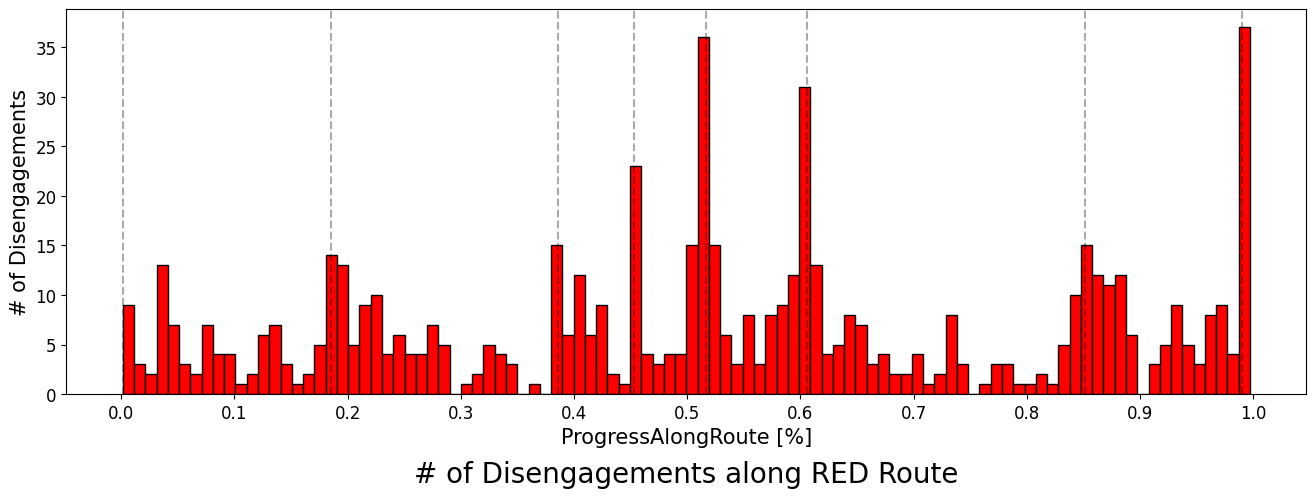

In [273]:
plt.figure( figsize = ( 16, 5 ) )

plt.hist( red_route_disengagement_progress_value_array, bins = 100, color = 'red', edgecolor = 'black' )

plt.xticks( np.linspace( 0, 1, 11 ) )

plt.xticks( fontsize = 12 )

plt.yticks( fontsize = 12 )

plt.xlabel( 'ProgressAlongRoute [%]', fontsize = 15 )

plt.ylabel( '# of Disengagements', fontsize = 15 )

plt.title( '# of Disengagements along RED Route', fontsize = 20, y = -0.25 )

#

highlight_points_wanted = [ 0, 0.185, 0.386, 0.453, 0.516, 0.606, 0.853, 0.99 ]

highlight_points_actual_indexes = []

highlight_points_actual = []

for point in highlight_points_wanted:

    temp_array = np.abs( red_route_disengagement_progress_value_array - point )

    index = np.where( temp_array == np.min( temp_array ) )[ 0 ][ 0 ]

    new_point = red_route_disengagement_progress_value_array[ index ]

    highlight_points_actual_indexes.append( index )

    highlight_points_actual.append( new_point )

    plt.axvline( x = new_point, color = 'black', ls = '--', alpha = 0.33 )

#

plt.show()

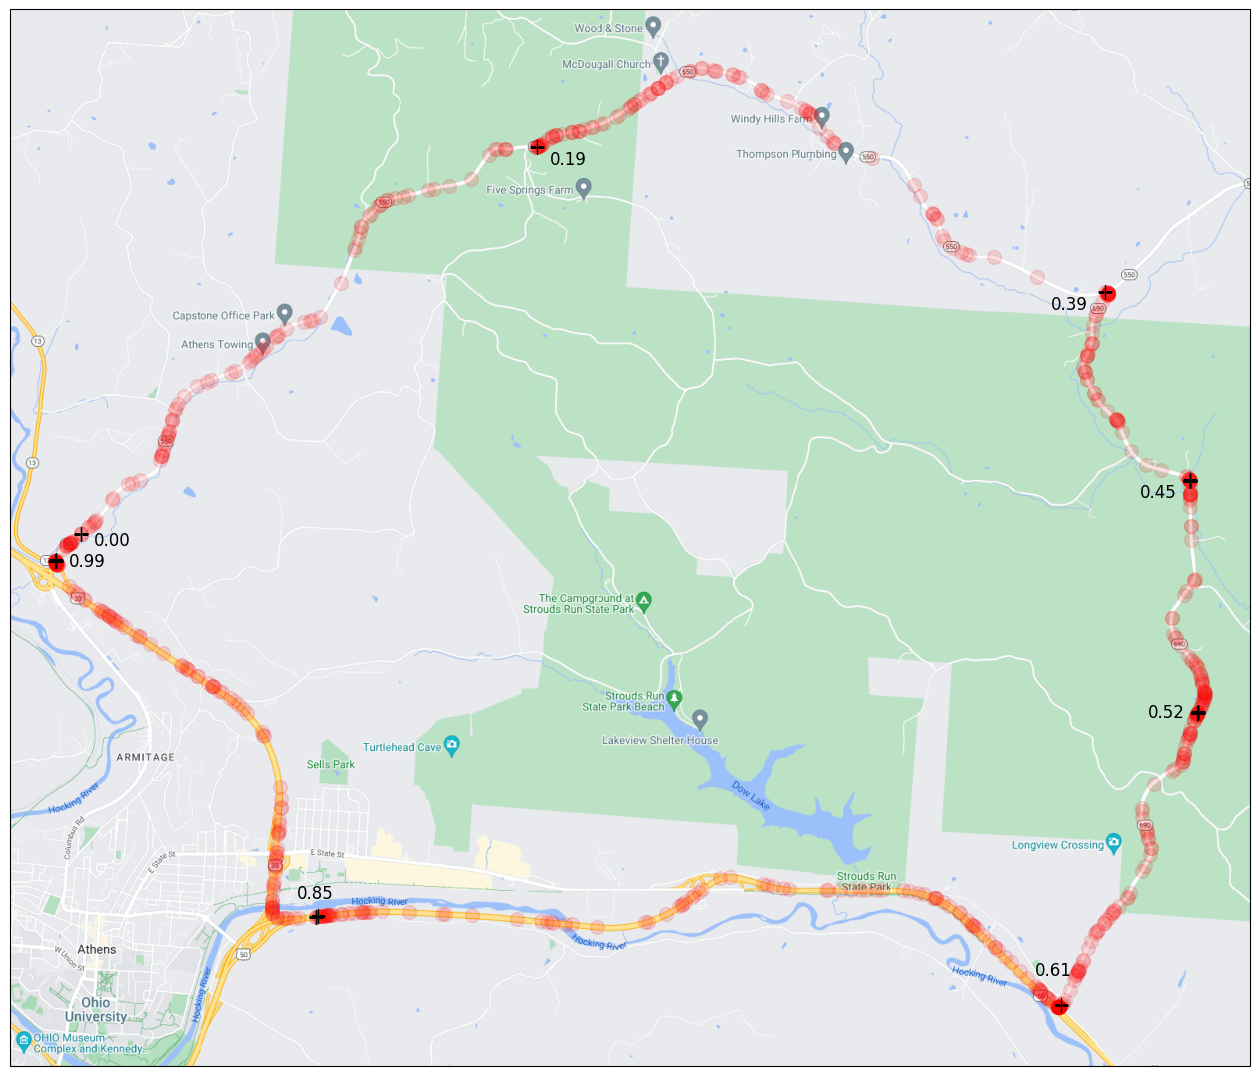

In [274]:
minLat = np.min( np.array( red_route_disengagement_subset_df_copy[ 'latitude' ] ) )

maxLat = np.max( np.array( red_route_disengagement_subset_df_copy[ 'latitude' ] ) )

minLon = np.min( np.array( red_route_disengagement_subset_df_copy[ 'longitude' ] ) )

maxLon = np.max( np.array( red_route_disengagement_subset_df_copy[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = imagery.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

# ax.gridlines( draw_labels = False, dms = True, x_inline = False, y_inline = False )

latitude_list = red_route_disengagement_subset_df_copy[ 'latitude' ]

longitude_list = red_route_disengagement_subset_df_copy[ 'longitude' ]

plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', color = 'red', alpha = 1 / 8, ms = 10 )

#

peaks_df = red_route_disengagement_subset_df_copy[ red_route_disengagement_subset_df_copy[ 'ProgressAlongRoute' ] \
                                                                                 .isin( highlight_points_actual ) ]

peak_latitude_list = np.array( peaks_df[ 'latitude' ] )

peak_longitude_list = np.array( peaks_df[ 'longitude' ] )

peak_progress_list = np.array( peaks_df[ 'ProgressAlongRoute' ] )

plt.plot( peak_longitude_list, peak_latitude_list, transform = ccrs.PlateCarree(), marker = '+', ls = '', color = 'black', alpha = 1, ms = 10 )

#

plt.text( peak_longitude_list[ 0 ] + 0.0035, peak_latitude_list[ 0 ], f'{ peak_progress_list[ 0 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 1 ] + 0.0035, peak_latitude_list[ 1 ] - 0.001, f'{ peak_progress_list[ 1 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 2 ] - 0.0035, peak_latitude_list[ 2 ], f'{ peak_progress_list[ 2 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 5 ] - 0.0035, peak_latitude_list[ 5 ] - 0.001, f'{ peak_progress_list[ 5 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 6 ] + 0.0035, peak_latitude_list[ 6 ] - 0.0005, f'{ peak_progress_list[ 6 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 7 ], peak_latitude_list[ 7 ] + 0.002, f'{ peak_progress_list[ 7 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ -2 ] - 0.0008, peak_latitude_list[ -2 ] + 0.003, f'{ peak_progress_list[ -2 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ -7 ] - 0.004, peak_latitude_list[ -7 ] - 0.001, f'{ peak_progress_list[ -7 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.show()

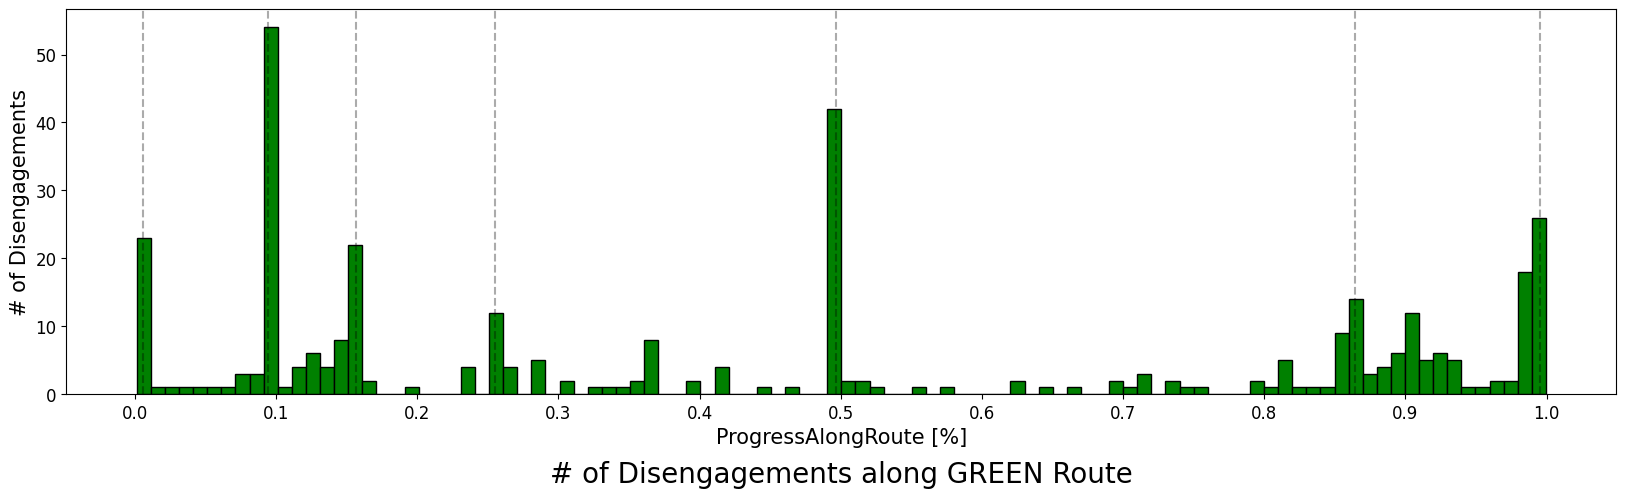

In [275]:
plt.figure( figsize = ( 20, 5 ) )

plt.hist( green_route_disengagement_progress_value_array, bins = 100, color = 'green', edgecolor = 'black' )

plt.xticks( np.linspace( 0, 1, 11 ) )

plt.xticks( fontsize = 12 )

plt.yticks( fontsize = 12 )

plt.xlabel( 'ProgressAlongRoute [%]', fontsize = 15 )

plt.ylabel( '# of Disengagements', fontsize = 15 )

plt.title( '# of Disengagements along GREEN Route', fontsize = 20, y = -0.25 )

#

highlight_points_wanted = [ 0.01, 0.095, 0.157, 0.25, 0.495, 0.865, 0.995 ]

highlight_points_actual_indexes = []

highlight_points_actual = []

for point in highlight_points_wanted:

    temp_array = np.abs( green_route_disengagement_progress_value_array - point )

    index = np.where( temp_array == np.min( temp_array ) )[ 0 ][ 0 ]

    new_point = green_route_disengagement_progress_value_array[ index ]

    highlight_points_actual_indexes.append( index )

    highlight_points_actual.append( new_point )

    plt.axvline( x = new_point, color = 'black', ls = '--', alpha = 0.33 )

#

plt.show()

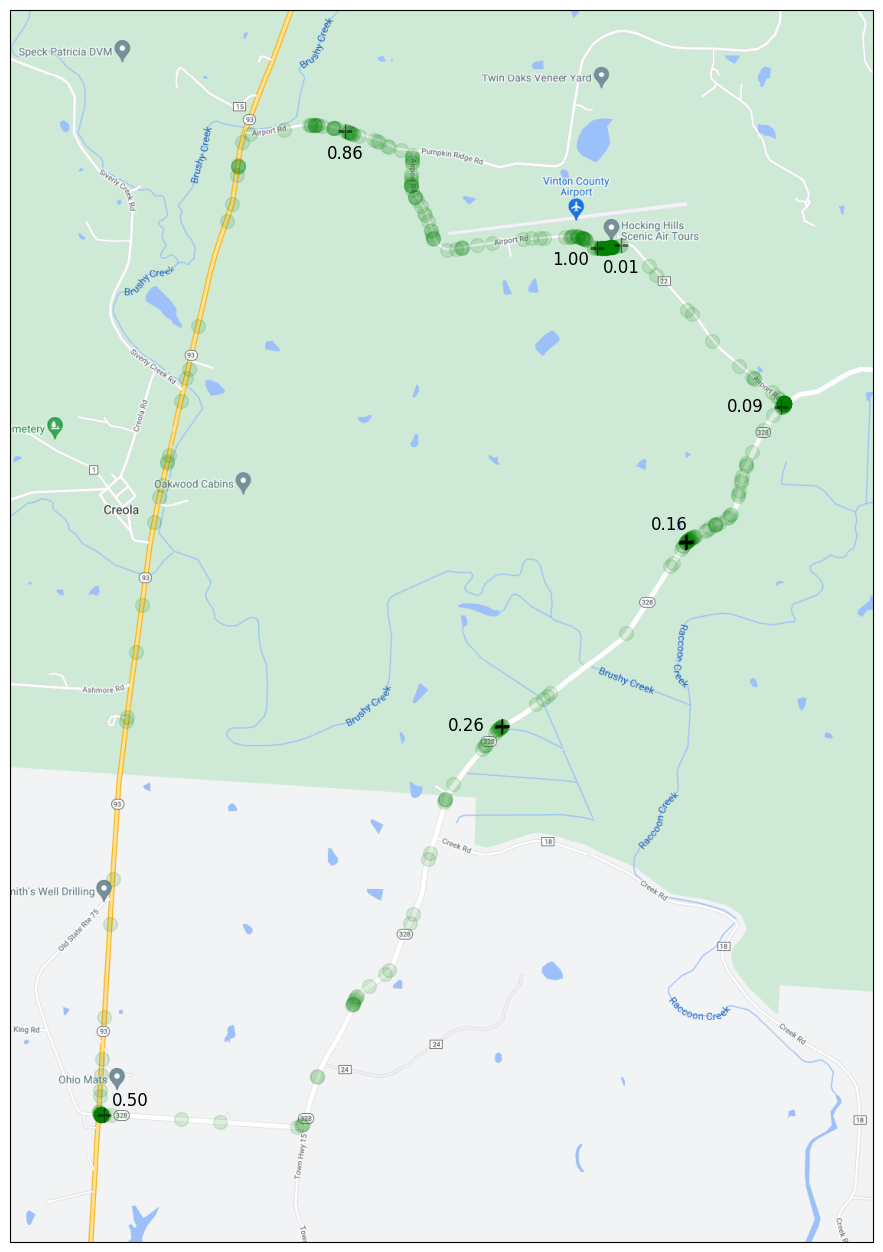

In [276]:
minLat = np.min( np.array( green_route_disengagement_subset_df_copy[ 'latitude' ] ) )

maxLat = np.max( np.array( green_route_disengagement_subset_df_copy[ 'latitude' ] ) )

minLon = np.min( np.array( green_route_disengagement_subset_df_copy[ 'longitude' ] ) )

maxLon = np.max( np.array( green_route_disengagement_subset_df_copy[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = imagery.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image( street_map, 15 )

# ax.gridlines( draw_labels = False, dms = True, x_inline = False, y_inline = False )

latitude_list = green_route_disengagement_subset_df_copy[ 'latitude' ]

longitude_list = green_route_disengagement_subset_df_copy[ 'longitude' ]

plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', color = 'green', alpha = 1 / 8, ms = 10 )

#

peaks_df = green_route_disengagement_subset_df_copy[ green_route_disengagement_subset_df_copy[ 'ProgressAlongRoute' ] \
                                                                                 .isin( highlight_points_actual ) ]

peak_latitude_list = np.array( peaks_df[ 'latitude' ] )

peak_longitude_list = np.array( peaks_df[ 'longitude' ] )

peak_progress_list = np.array( peaks_df[ 'ProgressAlongRoute' ] )

plt.plot( peak_longitude_list, peak_latitude_list, transform = ccrs.PlateCarree(), marker = '+', ls = '', color = 'black', alpha = 1 / 2, ms = 10 )

#

plt.text( peak_longitude_list[ 0 ] - 0.001, peak_latitude_list[ 0 ] + 0.0007, f'{ peak_progress_list[ 0 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 3 ] - 0.002, peak_latitude_list[ 3 ], f'{ peak_progress_list[ 3 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 4 ] + 0.0015, peak_latitude_list[ 4 ] + 0.0006, f'{ peak_progress_list[ 4 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 5 ] - 0.0015, peak_latitude_list[ 5 ] - 0.0005, f'{ peak_progress_list[ 5 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 6 ] - 0.002, peak_latitude_list[ 6 ], f'{ peak_progress_list[ 6 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 9 ], peak_latitude_list[ 9 ] - 0.001, f'{ peak_progress_list[ 9 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ -2 ], peak_latitude_list[ -2 ] - 0.001, f'{ peak_progress_list[ -2 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.show()

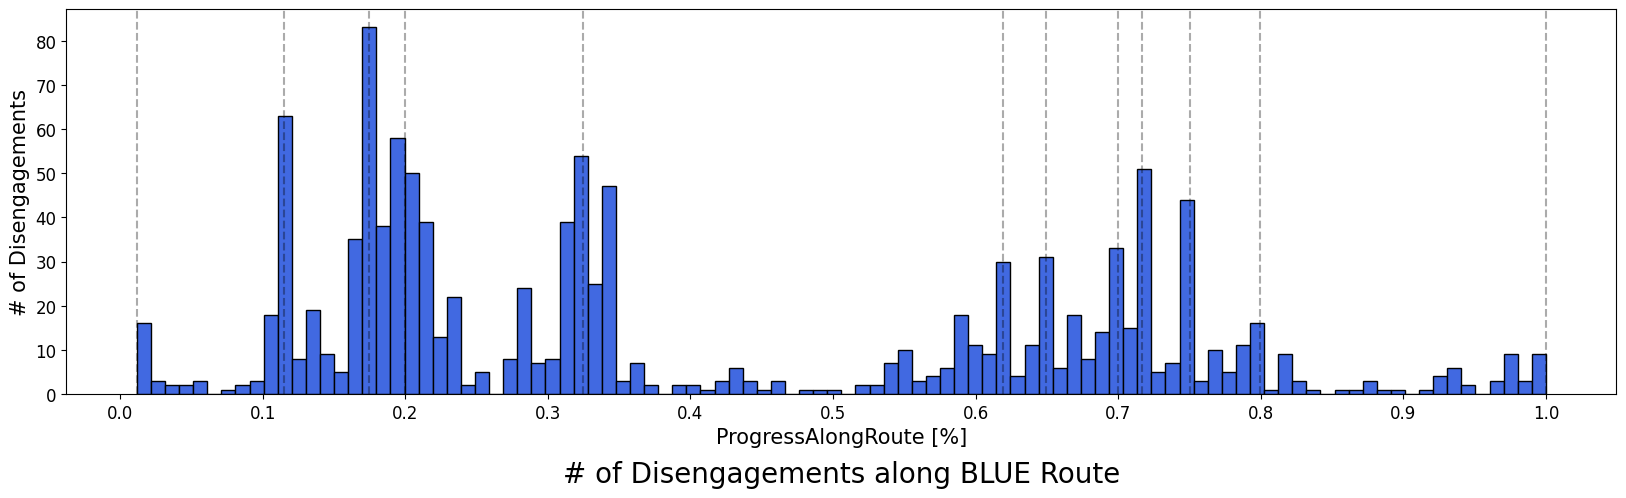

In [283]:
plt.figure( figsize = ( 20, 5 ) )

plt.hist( blue_route_disengagement_progress_value_array, bins = 100, color = 'royalblue', edgecolor = 'black' )

plt.xticks( np.linspace( 0, 1, 11 ) )

plt.xticks( fontsize = 12 )

plt.yticks( fontsize = 12 )

plt.xlabel( 'ProgressAlongRoute [%]', fontsize = 15 )

plt.ylabel( '# of Disengagements', fontsize = 15 )

plt.title( '# of Disengagements along BLUE Route', fontsize = 20, y = -0.25 )

#

highlight_points_wanted = [ 0, 0.115, 0.2, 0.175, 0.325, 0.62, 0.65, 0.7, 0.717, 0.75, 0.8, 1 ]

highlight_points_actual_indexes = []

highlight_points_actual = []

for point in highlight_points_wanted:

    temp_array = np.abs( blue_route_disengagement_progress_value_array - point )

    index = np.where( temp_array == np.min( temp_array ) )[ 0 ][ 0 ]

    new_point = blue_route_disengagement_progress_value_array[ index ]

    highlight_points_actual_indexes.append( index )

    highlight_points_actual.append( new_point )

    plt.axvline( x = new_point, color = 'black', ls = '--', alpha = 0.33 )

#

plt.show()

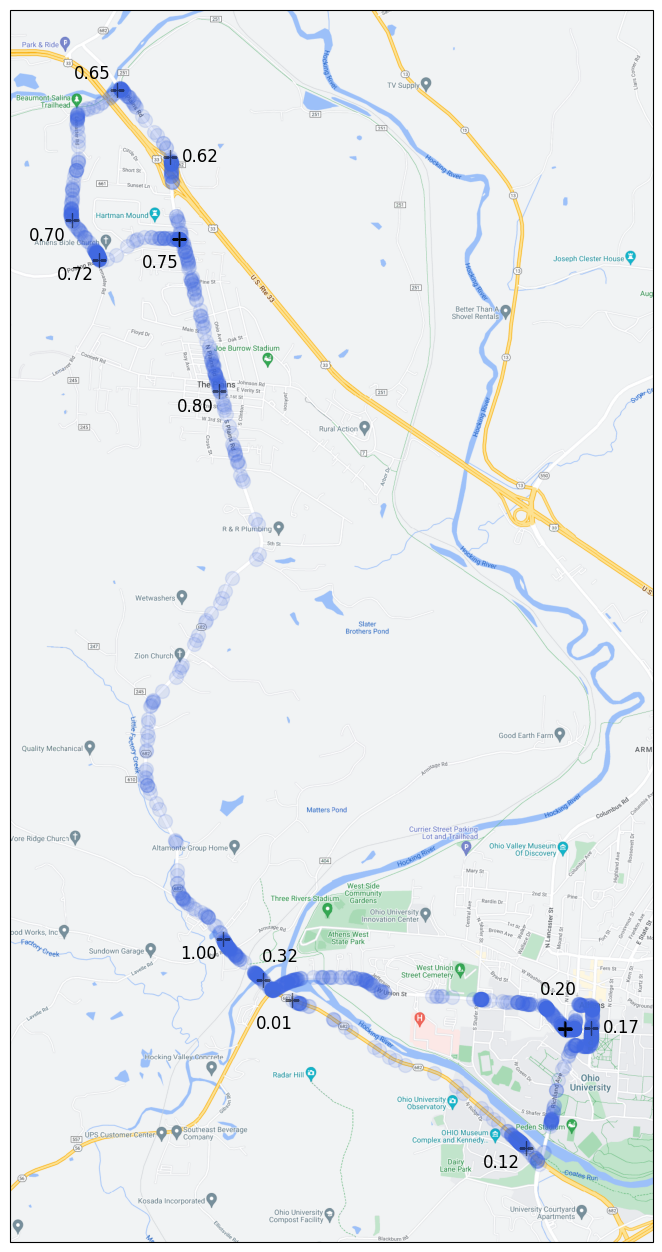

In [282]:
minLat = np.min( np.array( blue_route_disengagement_subset_df_copy[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_route_disengagement_subset_df_copy[ 'latitude' ] ) )

minLon = np.min( np.array( blue_route_disengagement_subset_df_copy[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_route_disengagement_subset_df_copy[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = imagery.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image( street_map, 15 )

# ax.gridlines( draw_labels = False, dms = True, x_inline = False, y_inline = False )

latitude_list = blue_route_disengagement_subset_df_copy[ 'latitude' ]

longitude_list = blue_route_disengagement_subset_df_copy[ 'longitude' ]

plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', color = 'royalblue', alpha = 1 / 8, ms = 10 )

#

peaks_df = blue_route_disengagement_subset_df_copy[ blue_route_disengagement_subset_df_copy[ 'ProgressAlongRoute' ] \
                                                                                 .isin( highlight_points_actual ) ]

peak_latitude_list = np.array( peaks_df[ 'latitude' ] )

peak_longitude_list = np.array( peaks_df[ 'longitude' ] )

peak_progress_list = np.array( peaks_df[ 'ProgressAlongRoute' ] )

plt.plot( peak_longitude_list, peak_latitude_list, transform = ccrs.PlateCarree(), marker = '+', ls = '', color = 'black', alpha = 1 / 2, ms = 10 )

#

plt.text( peak_longitude_list[ 0 ] - 0.0005, peak_latitude_list[ 0 ] + 0.0025, f'{ peak_progress_list[ 0 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 2 ] - 0.0015, peak_latitude_list[ 2 ] - 0.0015, f'{ peak_progress_list[ 2 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 3 ] + 0.0015, peak_latitude_list[ 3 ] + 0.0015, f'{ peak_progress_list[ 3 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 5 ] - 0.0015, peak_latitude_list[ 5 ] - 0.0015, f'{ peak_progress_list[ 5 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 10 ] - 0.002, peak_latitude_list[ 10 ] - 0.001, f'{ peak_progress_list[ 10 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 11 ] - 0.002, peak_latitude_list[ 11 ] - 0.001, f'{ peak_progress_list[ 11 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 14 ] - 0.002, peak_latitude_list[ 14 ] + 0.001, f'{ peak_progress_list[ 14 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 16 ] + 0.0025, peak_latitude_list[ 16 ], f'{ peak_progress_list[ 16 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 17 ] - 0.002, peak_latitude_list[ 17 ] - 0.001, f'{ peak_progress_list[ 17 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 18 ] - 0.002, peak_latitude_list[ 18 ] - 0.001, f'{ peak_progress_list[ 18 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 19 ] - 0.002, peak_latitude_list[ 19 ] - 0.001, f'{ peak_progress_list[ 19 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.text( peak_longitude_list[ 21 ] + 0.0025, peak_latitude_list[ 21 ], f'{ peak_progress_list[ 21 ] :.2f}', transform = ccrs.PlateCarree(), 
          color = 'black', fontsize = 12, ha = 'center', va = 'center' )

plt.show()